In [1]:
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import (
    DataStore,
    FixedPointingInfo,
    Observation,
    Observations,
    observatory_locations,
)
from gammapy.datasets import MapDataset, MapDatasetEventSampler, FluxPointsDataset, Datasets, SpectrumDataset
from gammapy.estimators import TSMapEstimator, FluxPointsEstimator, LightCurveEstimator
from gammapy.estimators.utils import get_rebinned_axis
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import (
    MapDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, WcsGeom, Map, RegionGeom, TimeMapAxis
from gammapy.maps import MapAxis, MapCoord, RegionNDMap, TimeMapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpDecayTemporalModel,
    FoVBackgroundModel,
    Models,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    TemplateSpatialModel,
)

In [2]:
import gammapy
gammapy.__version__

'1.2'

In [3]:
%env CALDB=../caldb/

env: CALDB=../caldb/


In [4]:
data_store = DataStore.from_dir("../output")

In [5]:
ra, dec = 166.11380868146 * u.deg, 38.20883291552 * u.deg
target = SkyCoord(166.11380868146 * u.deg, 38.20883291552 * u.deg, frame="icrs")
pointing = target.directional_offset_by(position_angle = 0 * u.deg, separation = 0.5 * u.deg)

In [6]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=pointing.ra.deg,
    lat=pointing.dec.deg,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

In [7]:
selected_obs_table = selected_obs_table[0:10]
#= selected_obs_table[0:30]

In [8]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])
print(observations[0])

Observation

	obs id            : 5000000063 
 	tstart            : 61774.25
	tstop             : 61774.26
	duration          : 445.00 s
	pointing (icrs)   : 166.1 deg, 38.9 deg

	deadtime fraction : 0.0%



In [9]:
energy_axis = MapAxis.from_energy_bounds(0.012, 10.0, 8, unit="TeV")

geom = WcsGeom.create(
    skydir=(pointing.ra.deg , pointing.dec.deg),
    binsz=0.01,
    width=(5, 5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.001, 40, 10, unit="TeV", name="energy_true"
)

In [10]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="src"
)

In [11]:
offset_max = 6 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max"], offset_max=offset_max
)

#circle = CircleSkyRegion(center=SkyCoord("257.045837402344 deg", "-44.3333320617676 deg"), radius=0.2 * u.deg)
#exclusion_mask = ~geom.region_mask(regions=[circle])
#maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)
maker_fov = FoVBackgroundMaker(method="fit")

In [12]:
for i, obs in enumerate(observations):
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.get_pointing_icrs(obs.tmid), width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"{i} of {len(observations)}, Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

print(stacked)

0 of 10, Background norm obs 5000000063: 1.21
1 of 10, Background norm obs 5000000064: 1.20
2 of 10, Background norm obs 5000000065: 1.20
3 of 10, Background norm obs 5000000066: 1.21
4 of 10, Background norm obs 5000000130: 1.32
5 of 10, Background norm obs 5000000131: 1.37
6 of 10, Background norm obs 5000000132: 1.33
7 of 10, Background norm obs 5000000133: 1.37
8 of 10, Background norm obs 5000000181: 1.18
9 of 10, Background norm obs 5000000183: 1.15
MapDataset
----------

  Name                            : src 

  Total counts                    : 42277 
  Total background counts         : 42275.97
  Total excess counts             : 1.03

  Predicted counts                : 42275.96
  Predicted background counts     : 42275.97
  Predicted excess counts         : nan

  Exposure min                    : 7.27e+03 m2 s
  Exposure max                    : 4.69e+09 m2 s

  Number of total bins            : 2000000 
  Number of fit bins              : 1250000 

  Fit statistic type  

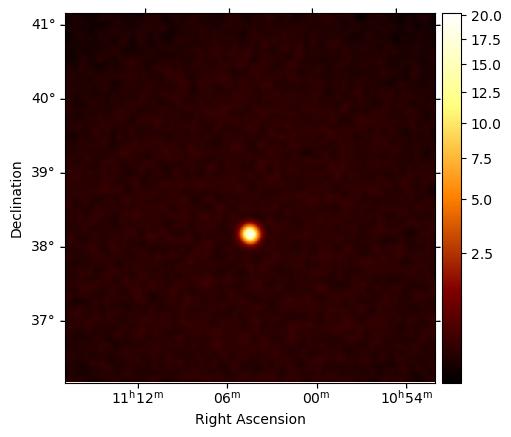

In [13]:
stacked.counts.sum_over_axes().smooth(0.04 * u.deg).plot(stretch="sqrt", add_cbar=True)
plt.show()

# Make a lightcurve

In [14]:
# define the time intervals
t0 = observations[0].tstart
tstop = observations[-1].tstop
#duration = 30 * u.min
duration = 1 * u.d
n_time_bins = int( ((tstop-t0)).to("s") / duration) + 10
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])]
#time_intervals

In [15]:
short_observations = observations.select_time(time_intervals)
# check that observations have been filtered
print(f"Number of observations after time filtering: {len(short_observations)}\n")
print(short_observations[1].gti)

Number of observations after time filtering: 11

GTI info:
- Number of GTIs: 1
- Duration: 450.0000002095476 s
- Start: 883894351.174 s MET
- Start: 2028-01-04T06:11:21.990 (time standard: UTC)
- Stop: 883894801.1740001 s MET
- Stop: 2028-01-04T06:18:51.990 (time standard: UTC)



In [16]:
# Target definition
energy_axis = MapAxis.from_energy_bounds("0.012 TeV", "10 TeV", nbin=10)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.001 TeV", "20 TeV", nbin=20, name="energy_true"
)

on_region_radius = Angle("0.10 deg")
on_region = CircleSkyRegion(center=target, radius=on_region_radius)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

In [17]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [18]:
datasets = Datasets()

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

for obs in short_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)

    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

In [19]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=2e-11 * u.Unit("1 / (cm2 s TeV)"), reference=1 * u.TeV
)
spectral_model.parameters["index"].frozen = False

sky_model = SkyModel(spatial_model=None, spectral_model=spectral_model, name="MRK 421")

In [20]:
datasets.models = sky_model

In [21]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.02, 10] * u.TeV,
    source="MRK 421",
    time_intervals=time_intervals,
    selection_optional="all",
)
lc_maker_1d.norm.scan_max = 10

In [22]:
lc_1d = lc_maker_1d.run(datasets)

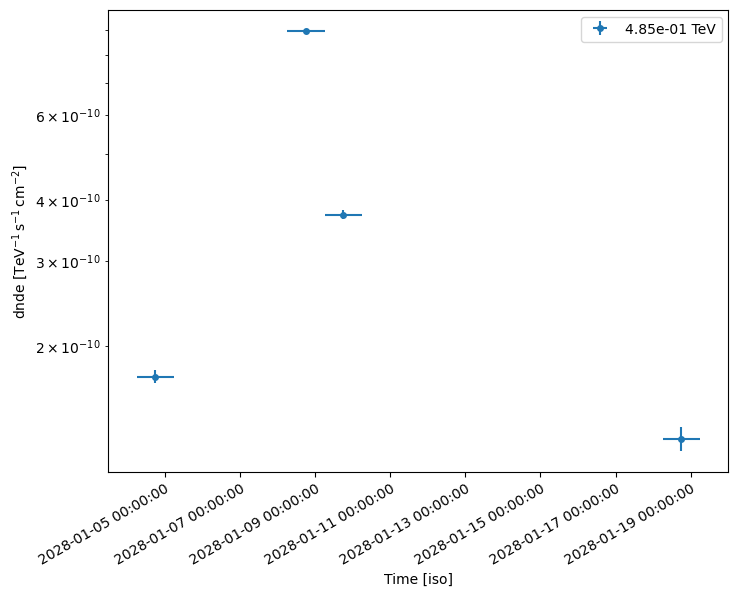

In [23]:
plt.figure(figsize=(8, 6))
lc_1d.plot(marker="o")
plt.show()

<Axes: xlabel='Time [iso]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

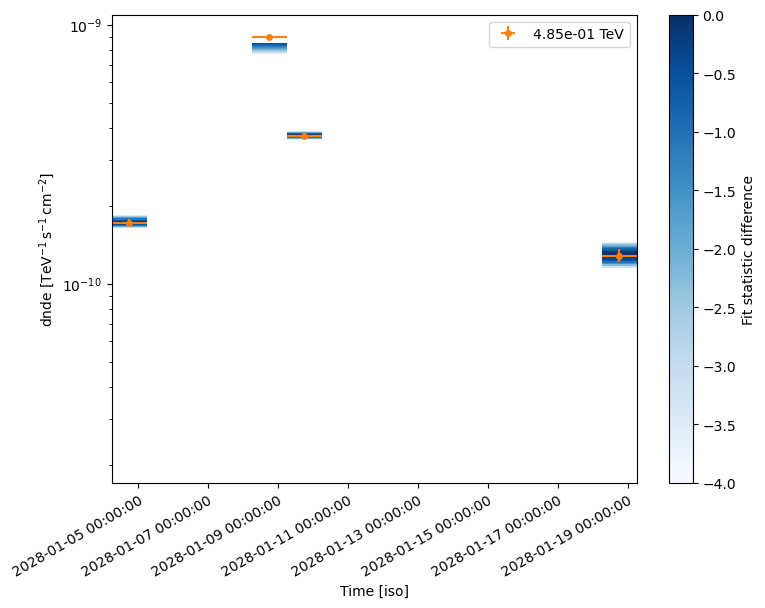

In [24]:
fig, ax = plt.subplots(
    figsize=(8, 6),
    gridspec_kw={"left": 0.16, "bottom": 0.2, "top": 0.98, "right": 0.98},
)

lc_1d.plot(ax=ax, color="tab:orange")
lc_1d.plot_ts_profiles()